In [4]:
import pandas as pd
import numpy as np

import os
import cv2
import glob

import tensorflow as tf

import keras
from keras.utils import to_categorical 
from keras.models import Sequential, Model
from keras.layers  import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping


from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from PIL import Image
import matplotlib.image as mpimg
from  matplotlib import pyplot as plt

%matplotlib inline

In [9]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
# load the images into memory
(x_train, y_train), (x_test, y_test) = load_data(path="mnist.npz")

In [10]:
x_train.shape[1:]

(28, 28)

In [11]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [10]:
x_train_scal = x_train/255.
x_test_scal = x_test/255.

x_train_scal_reshaped=x_train_scal.reshape((60000, 28, 28, 1))
x_test_scal_reshaped=x_test_scal.reshape((10000, 28, 28, 1))

y_train_onehot = to_categorical(y_train, 10)
y_test_onehot = to_categorical(y_test, 10)

In [11]:
# Initialize the model object
model2 = Sequential()

# Convolutional Layer
model2.add(Conv2D(filters = 32, kernel_size=(3,3), activation = 'relu', input_shape = (28, 28, 1)))
model2.add(MaxPooling2D(pool_size=(2,2)))

# Flattening layer and dense layer 
model2.add(Flatten())

model2.add(Dense(128, activation='relu'))

model2.add(Dense(10, activation='softmax')) 


model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               692352    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


In [70]:
epochs = 10
batch_size = 64

history = model2.fit(x_train_scal_reshaped, y_train_onehot, batch_size = batch_size,
                    epochs=epochs,   validation_split=0.10)


Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 22s 413us/step - loss: 0.1851 - accuracy: 0.9466 - val_loss: 0.0694 - val_accuracy: 0.9800
Epoch 2/10
54000/54000 [==============================] - 23s 431us/step - loss: 0.0615 - accuracy: 0.9818 - val_loss: 0.0608 - val_accuracy: 0.9825
Epoch 3/10
54000/54000 [==============================] - 21s 384us/step - loss: 0.0408 - accuracy: 0.9881 - val_loss: 0.0566 - val_accuracy: 0.9850
Epoch 4/10
54000/54000 [==============================] - 21s 381us/step - loss: 0.0283 - accuracy: 0.9914 - val_loss: 0.0553 - val_accuracy: 0.9843
Epoch 5/10
54000/54000 [==============================] - 21s 388us/step - loss: 0.0203 - accuracy: 0.9935 - val_loss: 0.0515 - val_accuracy: 0.9858
Epoch 6/10
54000/54000 [==============================] - 21s 392us/step - loss: 0.0150 - accuracy: 0.9954 - val_loss: 0.0534 - val_accuracy: 0.9870
Epoch 7/10
54000/54000 [==============================] 

In [76]:
scores = model2.evaluate(x_test_scal_reshaped, y_test_onehot, verbose=0)
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))

Accuracy: 0.9860000014305115 
 Error: 1.3999998569488525


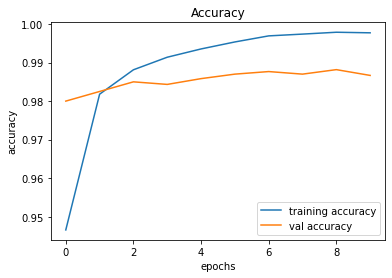

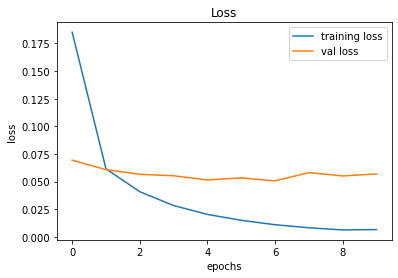

In [77]:
# fig, (ax1, ax2) = plt.subplots(1, 2)

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### RF

In [82]:
layer_name = 'dense_3'
CNN_model2 = Model(inputs=model2.input,
                                 outputs=model2.get_layer(layer_name).output)

In [90]:
LabelsRF = pd.DataFrame(y_train)

In [96]:
x_train.shape

(60000, 28, 28)

In [104]:
type(mnist[0][0])

numpy.ndarray

In [106]:
mnist.shape

(60000, 28, 28)

In [109]:
mnistreshape = mnist.reshape((60000, 28, 28,1))

In [110]:
FeaturesModel2 = []
for images in mnistreshape:
    images = np.expand_dims(images, axis = 0)
    image_outputs = CNN_model2.predict(images)
    FeaturesModel2.append(image_outputs)

In [111]:
features_df = pd.DataFrame(FeaturesModel2[0])
for i in FeaturesModel2:
    if i is not FeaturesModel2[0]:
       features_df =  features_df.append(pd.DataFrame(i))

In [112]:
x_trainRF, x_testRF, y_trainRF, y_testRF = train_test_split(features_df, LabelsRF, test_size=0.2, random_state=42, shuffle= True)

In [114]:
kfold = KFold(n_splits=5, random_state=42)

params_rf = {
    'n_estimators':[30, 40, 50],
    'min_samples_leaf':[2, 10, 30],
    'max_depth':  [50, 60, 80]
}

In [115]:

rf = RandomForestClassifier(random_state = 42)

grid_search_rf = GridSearchCV(rf, param_grid = params_rf, cv = kfold, scoring = 'accuracy')

grid_search_rf.fit(x_trainRF, y_trainRF) 

C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\mod

C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\mod

C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\mod

C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\mod

C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\mod

C:\Users\lenovo\Anaconda3\envs\MyEnviroment\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [50, 60, 80],
                         'min_samples_leaf': [2, 10, 30],
                         'n_estimators': [30, 40, 50]},
             scoring='accuracy')

In [116]:
best_model_rf = grid_search_rf.best_estimator_
best_model_rf

RandomForestClassifier(max_depth=50, min_samples_leaf=2, n_estimators=50,
                       random_state=42)

In [117]:
y_pred_rf = best_model_rf.predict(x_testRF) 
accuracyRF = accuracy_score(y_testRF, y_pred_rf)
accuracyRF

0.991

In [121]:
report = classification_report(y_testRF, y_pred_rf)
print(report) 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1175
           1       1.00      1.00      1.00      1322
           2       0.99      0.99      0.99      1174
           3       0.99      0.99      0.99      1219
           4       0.99      0.99      0.99      1176
           5       0.99      0.99      0.99      1104
           6       1.00      0.99      1.00      1177
           7       0.99      0.99      0.99      1299
           8       0.98      0.99      0.98      1160
           9       0.99      0.98      0.99      1194

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000

